In [ ]:
# Author: Brandon Botzer
# Date: 1/23/2024
# Class: Penn State - AI 879

Q2:

Implement an image blending algorithm for two images according to section 3.5.5 in Szeliski textbook. For this, please pick any two images of your choice.

In [1]:
# Imports for functions

# The scikit-image package provides a wide variety of filter applications
#  which reduce the need to write out the corr / conv matricies

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

In [2]:
# Read in the images and convert each to float 64 [0,1] scaling
im1 = ski.io.imread('apple.jpg')
im1 = ski.util.img_as_float64(im1)
im2 = ski.io.imread('orange.jpg')
im2 = ski.util.img_as_float64(im2)

In [3]:
# Creating the binary mask (a split down the middle)

# Get the size of the image as ints
size = int(im1.shape[0])
half_size = int(size/2)

# Create the mask and assign half of it to values of 1
mask = np.zeros((size, size, 3))
mask[:,0:half_size,:] = 1

# Invert the mask for the other image
inv_mask = ski.util.invert(mask)

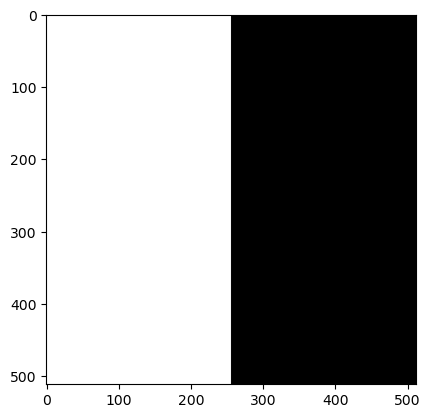

In [4]:
plt.imshow(mask)

In [5]:
mask.shape

(512, 512, 3)

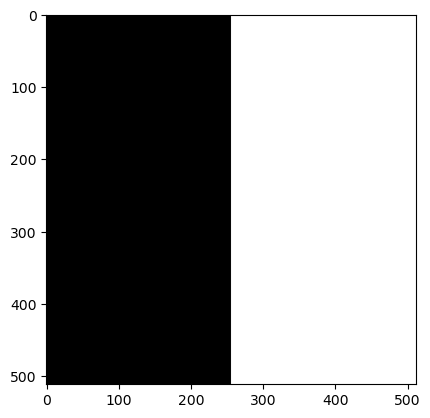

In [6]:
plt.imshow(inv_mask)

In [7]:
# Create Gaussian pyramids for both images and the mask

im1_gauss = list(ski.transform.pyramid_gaussian(im1, downscale=2, channel_axis=-1))
im2_gauss = list(ski.transform.pyramid_gaussian(im2, downscale=2, channel_axis=-1))
mask_gauss = list(ski.transform.pyramid_gaussian(mask, downscale=2, channel_axis=-1))
inv_mask_gauss = list(ski.transform.pyramid_gaussian(inv_mask, downscale=2, channel_axis=-1))

In [8]:
# Create Laplacian pyramids from the Gaussian pyramids for both image 1 and image 2

# I didn't actually have to compute the im1 and im2 Gaussians above as the pyramid_laplacian does this in smoothing
#  layer = resize(prev_layer) - smooth(resize(prev_layer))  as per: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.pyramid_laplacian

im1_lap = list(ski.transform.pyramid_laplacian(im1, downscale=2, channel_axis=-1))
im2_lap = list(ski.transform.pyramid_laplacian(im2, downscale=2, channel_axis=-1))

In [9]:
# Construct a blended Laplacian pyramid using each image Laplacian pyramid and weight by the corresponding Gaussian pyramid mask
#  When masking, make sure to mask on the correct sides.  Mask and 1-Mask will do this for im1 and im2

# Storage list for the blended Laplacian pyramid layers
blend_lap = []

for l1, l2, m, inv in zip(im1_lap, im2_lap, mask_gauss, inv_mask_gauss):

    print(l1.shape, l2.shape, m.shape, inv.shape) # Check your shapes, was having problems with this

    blend_lap.append(np.multiply(l1, m) + np.multiply(l2,inv)) # Use np.multipy() to ensure elementwise multiplication

(512, 512, 3) (512, 512, 3) (512, 512, 3) (512, 512, 3)
(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)
(128, 128, 3) (128, 128, 3) (128, 128, 3) (128, 128, 3)
(64, 64, 3) (64, 64, 3) (64, 64, 3) (64, 64, 3)
(32, 32, 3) (32, 32, 3) (32, 32, 3) (32, 32, 3)
(16, 16, 3) (16, 16, 3) (16, 16, 3) (16, 16, 3)
(8, 8, 3) (8, 8, 3) (8, 8, 3) (8, 8, 3)
(4, 4, 3) (4, 4, 3) (4, 4, 3) (4, 4, 3)
(2, 2, 3) (2, 2, 3) (2, 2, 3) (2, 2, 3)
(1, 1, 3) (1, 1, 3) (1, 1, 3) (1, 1, 3)


In [10]:
def LaplacianReconstruction(lap_pyr):
    '''Reconstruct the Laplacian image back to the origional image.
    Code based on and modified from AI879 lesson 6.1.

    Args:
        lap_pyr: The Laplacian pyramid used for reconstruction

    Returns:
        out_via_lap: The reconstructed image array
    '''

    # Start with the last image in the Laplacian pyramid for reconstruction
    out_via_lap = lap_pyr[-1]

    # Loop in reverse order all of the images in the Laplacian pyramid
    for lpy in reversed(lap_pyr):

        # Upscale through pyramid expansion to current smallest level of the pyramid
        out_via_lap = ski.transform.pyramid_expand(out_via_lap, upscale=2, order=1, channel_axis=-1) # order of 1 corresponds to 'bilinear' per: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp

        M, N, ch = lpy.shape

        out_via_lap = out_via_lap[:M, :N, :] + lpy

    return out_via_lap

In [11]:
# Reconstruct the blended Laplacian

im_blended = LaplacianReconstruction(blend_lap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


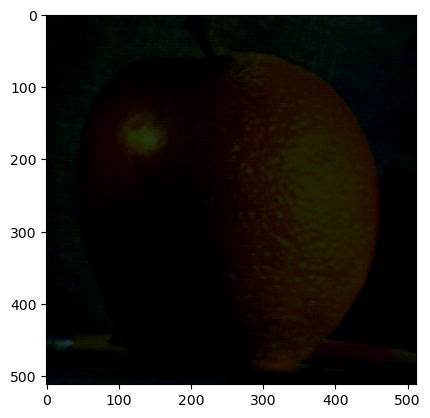

In [12]:
# Show the blended result
plt.imshow(im_blended)

I don't know why my images are turning out so dark.  I think it is either becasue I am using the full pyramids instead of a 32x32 that the multiresolutionPyramid (mrp) code uses or it is something within skimage Laplacian pyramid function.  The Laplacian pyramids are showing up very, very dark on display.

In [13]:
def pyramid_plotter(pyr_list):
    # Plot the output in a clever way to show the pyramid:
    #  From skimage example:  https://scikit-image.org/docs/stable/auto_examples/transform/plot_pyramid.html#sphx-glr-auto-examples-transform-plot-pyramid-py

    rows, cols, ch = pyr_list[0].shape

    # determine the total number of rows and columns for the composite
    #  Find the total number of rows of either the origional image or the pyramid rows summed
    composite_rows = max(rows, sum(p.shape[0] for p in pyr_list[1:]))
    #  Find the total number of columns by adding the origional and the first pyramid layer together
    #    all subsequent pyramid images will exist within this
    composite_cols = cols + pyr_list[1].shape[1]

    # Set the large grid to contain all of the images
    composite_image = np.zeros((composite_rows, composite_cols, 3),
                            dtype=np.double)

    # Store the original image to the left of the composite image
    composite_image[:rows, :cols, :] = pyr_list[0]

    # stack all downsampled images in a column to the right of the original

    i_row = 0 # Start the row count from the zero row (the top)
    # Loop for each layer in the pyramid
    for p in pyr_list[1:]:
        # Get the number of rows and columns for the current pyramid layer
        n_rows, n_cols = p.shape[:2]
        # From the last row position, add the current pyramid layer image
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
        # move the row count down for the next image
        i_row += n_rows

    # Plot the composite image
    fig, ax = plt.subplots()
    ax.imshow(composite_image)
    plt.show()

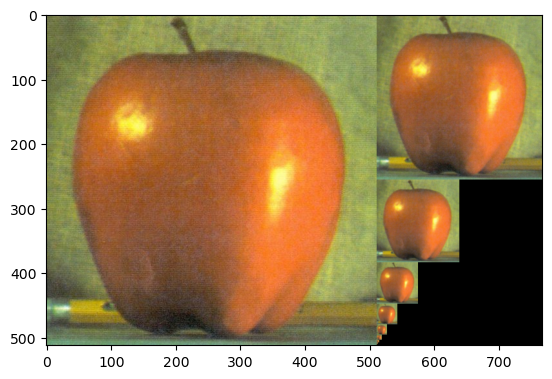

In [14]:
pyramid_plotter(im1_gauss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


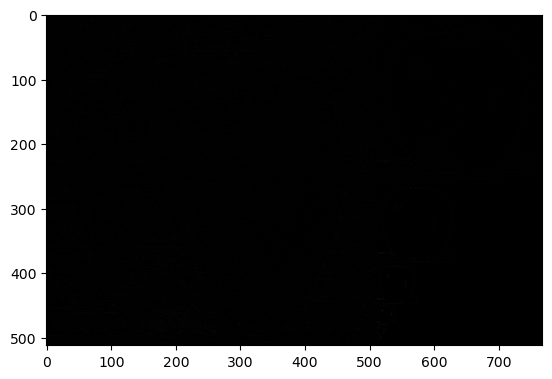

In [15]:
pyramid_plotter(im1_lap) # Should these Laplacians be this dark?

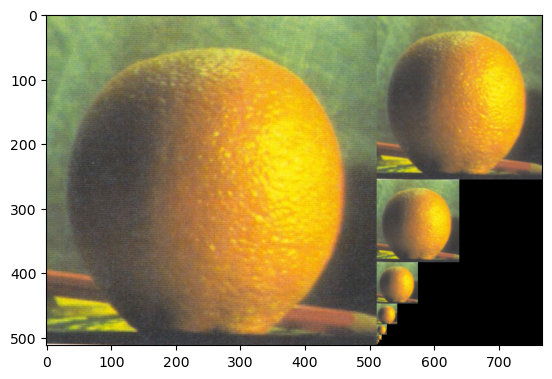

In [16]:
pyramid_plotter(im2_gauss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


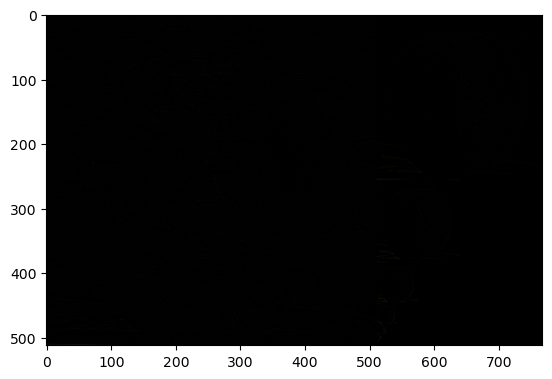

In [17]:
pyramid_plotter(im2_lap) # Should these Laplacians be this dark?

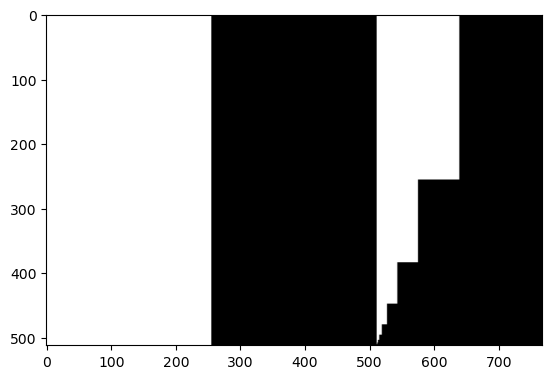

In [18]:
pyramid_plotter(mask_gauss)

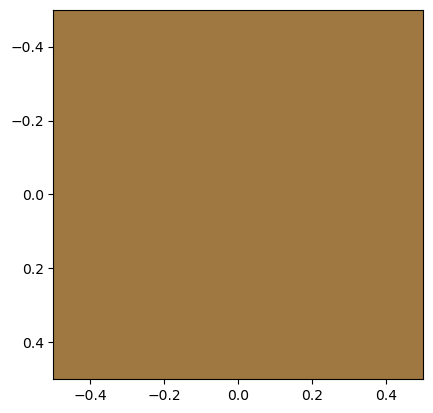

In [19]:
plt.imshow(im1_gauss[-1]) # Lowest Level

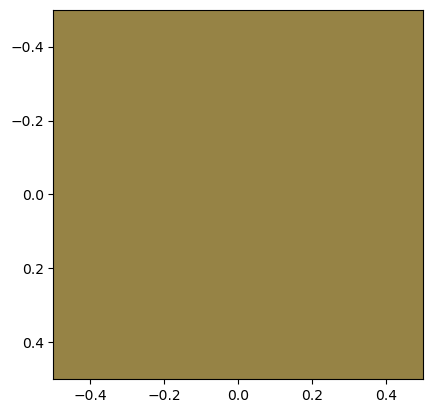

In [20]:
plt.imshow(im2_gauss[-1])